Что дало лучший результат на публичном лидерборде:

- Минимальный набор признаков (lagged rolling features и time features) и дефолтный CatBoost, direct предсказание сразу на 30 дней вперед.

Что пробовали:

- Простое экспоненциальное сглаживание
- Арима и Авто-арима с предварительных дифференцированием ряда, удаления сезонностей и тренда, box-cox.
- Auto-ml библиотека AutoGluon для временных рядов
- Отбор признаков и подбор гиперпараметров на кросс-валидации
- Рекурсивное предсказание по одному дню вперёд с помощью skforecast
- Facebook Prophet
- sktime TBATS

Что можно было ещё попробовать:

- Использовать информацию из таблицы, возможно можно было создать признаки, например, для каждого месяца среднее количество заказов, средняя сумма или средняя "звёздочность" отеля
- Различные ансамбли моделей
- DL-модели
- Добавить tsfresh признаки

Что заметили:

- Недельная и годовая сезонность
- Мультипликативный тренд
- Очень маленький горизонт предсказания и всего один временной ряд. Соответственно очень рандомно и сильно меняется RMSE при визуально валидных предсказаниях.
- Ряд очень нестабильный, поэтому для обучения использовали информацию после 2022 года.
- Чем больше признаков, тем хуже RMSE))
- Результат на кросс валидации не коррелирует с лидербордом. Всё очень рандомно

In [ ]:
!pip install gdown numpy pandas catboost matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.2 MB/s eta 0:00:00


In [ ]:
!gdown 1CRDYHRDaIZq5-C2qx-kCTp08_wX7nq4p
!gdown 1aUoru2dxe02W9cO4EJdCOj90YtgYXPwr
!gdown 148LnmUhQ-Id1qLjtu6-eoCyE3bdFDpsF
!unzip -o /content/train.zip

Downloading...
From (original): https://drive.google.com/uc?id=1CRDYHRDaIZq5-C2qx-kCTp08_wX7nq4p
From (redirected): https://drive.google.com/uc?id=1CRDYHRDaIZq5-C2qx-kCTp08_wX7nq4p&confirm=t&uuid=bec20fa8-274d-4fc2-9667-b5f8fb6857d1
To: /content/train.zip
100% 116M/116M [00:07<00:00, 16.5MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aUoru2dxe02W9cO4EJdCOj90YtgYXPwr
To: /content/sample_submission.csv
100% 501/501 [00:00<00:00, 1.76MB/s]
Downloading...
From: https://drive.google.com/uc?id=148LnmUhQ-Id1qLjtu6-eoCyE3bdFDpsF
To: /content/train_extra.csv
100% 24.9M/24.9M [00:00<00:00, 37.3MB/s]
Archive:  /content/train.zip
  inflating: train.csv               


In [ ]:
import random

import numpy as np
import pandas as pd
from catboost import CatBoostRegressor
from matplotlib import pyplot as plt

seed = 0
np.random.seed(seed)
random.seed(seed)

In [ ]:
df = pd.read_csv("/content/train.csv")
df_extra = pd.read_csv("/content/train_extra.csv")
df = pd.concat([df, df_extra], ignore_index=True)
df["service_date"] = pd.to_datetime(df["service_date"])
df = df.drop("index", axis=1)

In [ ]:
df

,service_date,service_status,sum_price,hotel_id,hotel_category_star,hotel_max_rooms,hotel_type,city_name,region_name,country_name
0,2018-10-03,"Аннулировано, без штрафа",5117.000000,1037,4.0,74.0,hotel,Якутск,Якутия,Россия
1,2019-04-02,Подтвержден,2850.899902,5222,0.0,15.0,mini-hotel,Белгород,Белгородская область,Россия
2,2023-09-28,Подтвержден,3700.000000,35751,3.0,16.0,hotel,Жуковский,Московская область,Россия
3,2019-04-27,Подтвержден,15603.200195,2428,2.0,37.0,hotel,Казань,Татарстан,Россия
4,2023-04-08,Подтвержден,5915.000000,103399,3.0,105.0,hotel,Краснодар,Краснодарский край,Россия
...,...,...,...,...,...,...,...,...,...,...
5594441,2024-06-01,Подтвержден,17419.500000,4606,3.0,215.0,hotel,Минск,NaN,Беларусь
5594442,2024-06-16,Подтвержден,5000.000000,31432,0.0,18.0,hotel,Краснодар,Краснодарский край,Россия
5594443,2024-06-23,"Аннулировано, без штрафа",7872.359863,24751,0.0,10.0,furnished-rooms,Санкт-Петербург,Санкт-Петербург,Россия
5594444,2024-06-24,Подтвержден,66960.000000,6576,3.0,9.0,mini-hotel,Михайловка село,Оренбургская область,Россия


In [ ]:
print((df["sum_price"] < 0).sum())
df["sum_price"] = df["sum_price"].apply(lambda x: abs(x))

3


<Axes: xlabel='service_date'>

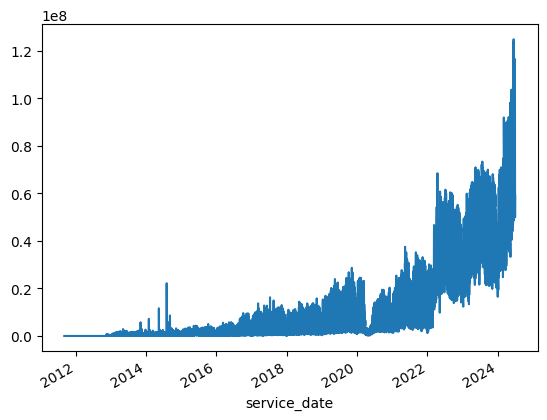

In [ ]:
train = df.groupby(["service_date"])["sum_price"].sum()
train.plot()

<Axes: xlabel='service_date'>

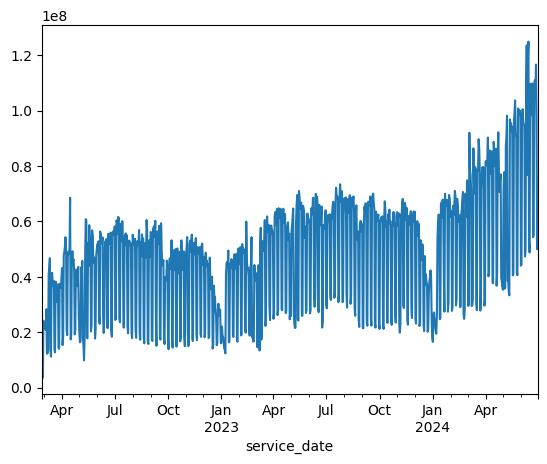

In [ ]:
train_after_2022 = train[train.index > "2022-02-24"]
train_after_2022.plot()

In [ ]:
train_after_2022 = train_after_2022.reset_index()
train_after_2022.columns = ["date", "forecast_value"]

In [ ]:
# submission = pd.read_csv("/content/sample_submission.csv")
submission = pd.DataFrame(
    {"date": pd.date_range(start="2024-07-01", end="2024-07-31"), "forecast_value": 0.0}
)
train_after_2022 = pd.concat([train_after_2022, submission], axis=0)

In [ ]:
train_after_2022 = train_after_2022.reset_index(drop=True)
train_after_2022["date"] = pd.to_datetime(train_after_2022["date"])
train_after_2022 = train_after_2022.sort_values(by="date")

In [ ]:
def create_time_features(df):
    df = df.copy()
    df["month"] = df.date.dt.month.astype("int8")
    df["day_of_month"] = df.date.dt.day.astype("int8")
    df["day_of_year"] = df.date.dt.dayofyear.astype("int16")
    df["week_of_month"] = (df.date.apply(lambda d: (d.day - 1) // 7 + 1)).astype("int8")
    df["week_of_year"] = (df.date.dt.isocalendar().week).astype("int8")
    df["day_of_week"] = (df.date.dt.dayofweek + 1).astype("int8")
    df["year"] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df["is_month_start"] = df.date.dt.is_month_start.astype("int8")
    df["is_month_end"] = df.date.dt.is_month_end.astype("int8")
    df["is_quarter_start"] = df.date.dt.is_quarter_start.astype("int8")
    df["is_quarter_end"] = df.date.dt.is_quarter_end.astype("int8")
    df["is_year_start"] = df.date.dt.is_year_start.astype("int8")
    df["is_year_end"] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12, 1, 2]), 0, 1)
    df["season"] = np.where(df.month.isin([6, 7, 8]), 2, df["season"])
    df["season"] = pd.Series(
        np.where(df.month.isin([9, 10, 11]), 3, df["season"])
    ).astype("int8")
    return df


train_with_features = create_time_features(train_after_2022)

In [ ]:
def create_rolling_features(df, column, lags, windows):
    df = df.copy()
    for lag in lags:
        lagged_col = df[column].shift(lag)

        # df[f'lag_{lag}'] = lagged_col

        for window in windows:

            df[f"rolling_mean_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).mean()
            df[f"rolling_median_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).median()

            # Sum
            df[f"rolling_sum_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window, min_periods=1
            ).sum()

            # df[f'rolling_mean_percentile_lag{lag}_win{window}_dow'] = (
            #     df.groupby('day_of_week')[column]
            #       .transform(lambda x: x.shift(lag // 7).rolling(window=window, min_periods=1).mean())
            # )

            # df[f'rolling_median_percentile_lag{lag}_win{window}_dow'] = (
            #     df.groupby('day_of_week')[column]
            #       .transform(lambda x: x.shift(lag // 7).rolling(window=window, min_periods=1).median())
            # )

            # # Min and Max
            # df[f'rolling_min_lag{lag}_win{window}'] = lagged_col.rolling(window=window).min()
            # df[f'rolling_max_lag{lag}_win{window}'] = lagged_col.rolling(window=window).max()

            # # Standard Deviation
            # df[f'rolling_std_lag{lag}_win{window}'] = lagged_col.rolling(window=window).std()

            # # Skewness
            # df[f'rolling_skew_lag{lag}_win{window}'] = lagged_col.rolling(window=window).skew()

            # Percentiles
            df[f"rolling_10th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).quantile(0.1)
            df[f"rolling_90th_percentile_lag{lag}_win{window}"] = lagged_col.rolling(
                window=window
            ).quantile(0.9)

            # df[f'rolling_10th_percentile_lag{lag}_win{window}_dow'] = (
            #     df.groupby('day_of_week')[column]
            #       .transform(lambda x: x.shift(lag // 7).rolling(window=window, min_periods=1).quantile(0.1))
            # )

            # df[f'rolling_90th_percentile_lag{lag}_win{window}_dow'] = (
            #     df.groupby('day_of_week')[column]
            #       .transform(lambda x: x.shift(lag // 7).rolling(window=window, min_periods=1).quantile(0.9))
            # )

    return df


lags = [31]
windows = [5, 7, 14, 21, 28, 35, 42]

In [ ]:
catboost_train = create_rolling_features(
    train_with_features, "forecast_value", lags, windows
)[max(lags) + max(windows) - 1 :]
catboost_train

,date,forecast_value,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,...,rolling_mean_lag31_win35,rolling_median_lag31_win35,rolling_sum_lag31_win35,rolling_10th_percentile_lag31_win35,rolling_90th_percentile_lag31_win35,rolling_mean_lag31_win42,rolling_median_lag31_win42,rolling_sum_lag31_win42,rolling_10th_percentile_lag31_win42,rolling_90th_percentile_lag31_win42
72,2022-05-08,1.514204e+07,5,8,128,2,18,7,2022,1,...,3.135027e+07,3.681730e+07,1.097259e+09,1.279643e+07,4.740837e+07,2.908442e+07,3.295337e+07,1.221546e+09,1.236471e+07,4.635636e+07
73,2022-05-09,9.825085e+06,5,9,129,2,19,1,2022,0,...,3.222038e+07,3.721944e+07,1.127713e+09,1.279643e+07,4.843930e+07,2.964471e+07,3.534946e+07,1.245078e+09,1.236471e+07,4.775517e+07
74,2022-05-10,1.762725e+07,5,10,130,2,19,2,2022,0,...,3.200158e+07,3.721944e+07,1.120055e+09,1.279643e+07,4.843930e+07,3.002023e+07,3.534946e+07,1.260850e+09,1.273490e+07,4.775517e+07
75,2022-05-11,4.829715e+07,5,11,131,2,19,3,2022,0,...,3.219280e+07,3.721944e+07,1.126748e+09,1.314769e+07,4.843930e+07,3.038512e+07,3.534946e+07,1.276175e+09,1.297654e+07,4.775517e+07
76,2022-05-12,6.079357e+07,5,12,132,2,19,4,2022,0,...,3.318088e+07,3.724926e+07,1.161331e+09,1.369319e+07,4.843930e+07,3.092676e+07,3.588089e+07,1.298924e+09,1.297654e+07,4.777454e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
883,2024-07-27,0.000000e+00,7,27,209,4,30,6,2024,1,...,8.699224e+07,9.813730e+07,3.044728e+09,4.548374e+07,1.104713e+08,8.600633e+07,9.675495e+07,3.612266e+09,4.404682e+07,1.097976e+08
884,2024-07-28,0.000000e+00,7,28,210,4,30,7,2024,1,...,8.772118e+07,9.830802e+07,3.070241e+09,4.548374e+07,1.143174e+08,8.657581e+07,9.771390e+07,3.636184e+09,4.404682e+07,1.108008e+08
885,2024-07-29,0.000000e+00,7,29,211,5,31,1,2024,0,...,8.788269e+07,9.830802e+07,3.075894e+09,4.548374e+07,1.143174e+08,8.664195e+07,9.771390e+07,3.638962e+09,4.404682e+07,1.108008e+08
886,2024-07-30,0.000000e+00,7,30,212,5,31,2,2024,0,...,8.813671e+07,9.830802e+07,3.084785e+09,4.790305e+07,1.143174e+08,8.686655e+07,9.771390e+07,3.648395e+09,4.456005e+07,1.108008e+08


In [ ]:
catboost_train = catboost_train.drop("date", axis=1)

In [ ]:
X_train = catboost_train[: -len(submission)].drop("forecast_value", axis=1)
y_train = catboost_train[: -len(submission)]["forecast_value"]
X_test = catboost_train[-len(submission) :].drop("forecast_value", axis=1)

In [ ]:
model = CatBoostRegressor(iterations=1000, random_seed=0, verbose=0)
model.fit(X_train, y_train)
model.save_model("catboost_default.cbm")
pred = model.predict(X_test)

In [ ]:
# feature importances
pd.DataFrame(zip(X_train.columns, model.feature_importances_)).sort_values(
    by=1, ascending=False
).head(50)

,0,1
5,day_of_week,58.610969
2,day_of_year,3.541386
6,year,3.026122
4,week_of_year,2.766958
15,season,1.904802
42,rolling_median_lag31_win35,1.826100
39,rolling_10th_percentile_lag31_win28,1.634781
41,rolling_mean_lag31_win35,1.451857
49,rolling_10th_percentile_lag31_win42,1.407910
24,rolling_10th_percentile_lag31_win7,1.177368


<Axes: >

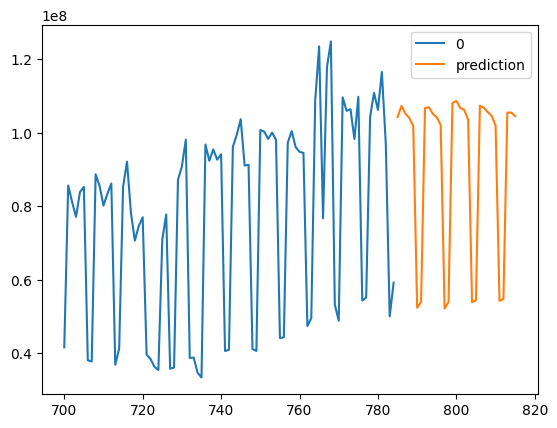

In [ ]:
pred_df = pd.DataFrame(pred)
pred_df["index"] = range(y_train.index.max(), y_train.index.max() + len(pred))
pred_df = pred_df.set_index("index")
pred_df.columns = ["prediction"]
pd.concat([y_train, pred_df], ignore_index=True)[700:].plot()

In [ ]:
submission["forecast_value"] = pred
submission.to_csv("catboost_default.csv", index=False)